In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
import scipy as sp

tex_fonts = {
    "text.usetex": True,
    "font.family": "serif",
    "axes.labelsize": 10,
    "font.size": 10,
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10
    }
plt.rcParams.update(tex_fonts)

In [2]:
# read in data
df_NO2 = pd.read_csv('../air_weather_data/NO2_all_stations_cleaned.csv')
df_NO2['date'] = pd.to_datetime(df_NO2['date'], format = '%Y-%m-%d %H:%M') # change time column to pandas datetime
df_NO2 = df_NO2.set_index('date') # date column as index

df_weather = pd.read_csv('../air_weather_data/metdata.csv')
df_weather['date'] = pd.to_datetime(df_weather['date'], format = '%Y-%m-%d %H:%M') # change time column to pandas datetime
df_weather = df_weather.set_index('date') # date column as index

In [3]:
# drop negative and zero values and interpolate (in order to log transform)
df_NO2[df_NO2 <= 0] = np.NaN
df_NO2.interpolate(inplace=True)

In [4]:
# df_NO2['NO$_2$, Stockholm Torkel Knutssonsgatan'] = np.log(df_NO2['NO$_2$, Stockholm Torkel Knutssonsgatan'])

In [5]:
# create lagged values
for i in df_NO2.columns:
    df_NO2[str(i) + ', lag1'] = df_NO2[i].shift(1)

# additional lags for the target station
lags = 2
j = 2
for i in range(lags-1):
    df_NO2['NO$_2$, Stockholm Torkel Knutssonsgatan' + ', lag' + \
        str(j)] = df_NO2['NO$_2$, Stockholm Torkel Knutssonsgatan'].shift(j)
    j += 1

# # add lag 24 and 25 (since found sign.)
# df_NO2['NO$_2$, Stockholm Torkel Knutssonsgatan, lag 23'] = df_NO2['NO$_2$, Stockholm Torkel Knutssonsgatan'].shift(23)
# df_NO2['NO$_2$, Stockholm Torkel Knutssonsgatan, lag 24'] = df_NO2['NO$_2$, Stockholm Torkel Knutssonsgatan'].shift(24)
# df_NO2['NO$_2$, Stockholm Torkel Knutssonsgatan, lag 25'] = df_NO2['NO$_2$, Stockholm Torkel Knutssonsgatan'].shift(25)

# drop NaN values
df_NO2.dropna(inplace=True)

In [6]:
# split into train, val, and test sets
df_NO2_train = df_NO2['2016-01-01 00:00':'2019-01-01 00:00']
df_NO2_val = df_NO2['2019-01-01 01:00:00':'2020-01-01 00:00:00']
df_NO2_test = df_NO2['2021-01-25 16:00:00':]

df_weather_train = df_weather['2016-01-01 00:00':'2019-01-01 00:00']
df_weather_val = df_weather['2019-01-01 01:00:00':'2020-01-01 00:00:00']
df_weather_test = df_weather['2021-01-25 16:00:00':]

In [7]:
# index needed if normalizing below
index_train = df_NO2_train.index 
index_val = df_NO2_val.index
index_test = df_NO2_test.index

In [8]:
# log transform data
df_NO2_train = np.log(df_NO2_train)
df_NO2_val = np.log(df_NO2_val)
df_NO2_test = np.log(df_NO2_test)

In [9]:
# if only some stations are to be included, but include all lagged values at Torkel Knutssonsgatan
stations = [i for i in df_NO2_train.columns if 'Torkel' in i and 'lag' in i] + \
           [
            'NO$_2$, Stockholm Hornsgatan 108, lag1',
            'NO$_2$, Stockholm Sveavägen 59, lag1',
            'NO$_2$, Stockholm E4/E20 Lilla Essingen, lag1',
            # 'NO$_2$, Norr Malma, lag1',
            # 'NO$_2$, Stockholm Sveavägen 59 Tak, lag1',
           ]

In [10]:
# create y and X matrix for train, val, and test sets
y_train = df_NO2_train['NO$_2$, Stockholm Torkel Knutssonsgatan']
X_train = df_NO2_train[stations]

y_val = df_NO2_val['NO$_2$, Stockholm Torkel Knutssonsgatan']
X_val = df_NO2_val[stations]

y_test = np.exp(df_NO2_test['NO$_2$, Stockholm Torkel Knutssonsgatan']) # y_test should be on original scale
X_test = df_NO2_test[stations]

In [12]:
from sklearn.preprocessing import MinMaxScaler
# normalize data (standardscaler also tested which gave the same result)
# two scalers, one for X and on for y 
scaler1 = MinMaxScaler() 
scaler2 = MinMaxScaler()

# normalize train set
X_train = scaler1.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=stations)
X_train.insert(0, 'date', index_train)
X_train.set_index('date', inplace=True)

y_train = scaler2.fit_transform(y_train.to_frame())
y_train = pd.DataFrame(y_train, columns = ['NO$_2$, Torkel Knutssonsgatan'])
y_train.insert(0, 'date', index_train)
y_train.set_index('date', inplace=True)

# normalize validation set
X_val = scaler1.transform(X_val) # fit is not used here to only use statistics from train data
X_val = pd.DataFrame(X_val, columns=stations)
X_val.insert(0, 'date', index_val)
X_val.set_index('date', inplace=True)

y_val = scaler2.transform(y_val.to_frame()) # fit is not used here to only use statistics from train data
y_val = pd.DataFrame(y_val, columns = ['NO$_2$, Torkel Knutssonsgatan'])
y_val.insert(0, 'date', index_val)
y_val.set_index('date', inplace=True)

# normalize test set (except y which is kept as it is since we want to predict on original scale)
X_test = scaler1.transform(X_test) # not fit here to use statistics from train data
X_test = pd.DataFrame(X_test, columns=stations)
X_test.insert(0, 'date', index_test)
X_test.set_index('date', inplace=True)

In [13]:
# np.exp(scaler2.inverse_transform((y_train)))

In [14]:
X_train.insert(0, 'intercept', 1) # insert a 1

In [15]:
# if temporal signals are to be included
w = [0,2,4,5] # 0:temp, 1:atm, 2:RH, 3:precip, 4:solrad, 5:wind 
s = [6,7] # 6,7:day, 8,9:week, 10,11:year

X_train = X_train.merge(df_weather_train.iloc[:,s], on='date')
# if weather parameters are to be included
df_weather_train = df_weather_train.iloc[:,w]
df_weather_norm_train = (df_weather_train - df_weather_train.min())/(df_weather_train.max() - df_weather_train.min())
X_train = X_train.merge(df_weather_norm_train, on='date')

In [16]:
X_val = X_val.merge(df_weather_val.iloc[:,s], on='date')
df_weather_val = df_weather_val.iloc[:,w]
df_weather_norm_val = (df_weather_val - df_weather_val.min())/(df_weather_val.max() - df_weather_val.min())
X_val = X_val.merge(df_weather_norm_val, on='date')

# OLS regression

In [17]:
# fit OLS regression model
lmod = sm.OLS(y_train, X_train).fit()
print(lmod.summary().as_latex())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}                                   & NO\$\_2\$, Torkel Knutssonsgatan & \textbf{  R-squared:         } &     0.852   \\
\textbf{Model:}                                           &               OLS                & \textbf{  Adj. R-squared:    } &     0.852   \\
\textbf{Method:}                                          &          Least Squares           & \textbf{  F-statistic:       } & 1.381e+04   \\
\textbf{Date:}                                            &         Wed, 31 Aug 2022         & \textbf{  Prob (F-statistic):} &     0.00    \\
\textbf{Time:}                                            &             15:42:00             & \textbf{  Log-Likelihood:    } &    39098.   \\
\textbf{No. Observations:}                                &               26305              & \textbf{  AIC:               } & -7.817e+04  \\
\textbf{Df Residuals:}                                    &               26293              & \

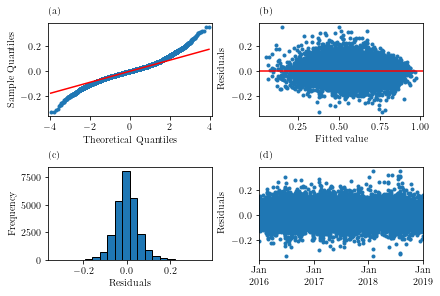

In [18]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, constrained_layout = True, figsize = (6, 4))

# QQ-plot of studentized residuals
sm.qqplot(lmod.resid, line='q', ax=ax1, marker=".")
ax1.annotate('(a)', xy=(0, 1.09), xycoords="axes fraction")

# fitted vs residuals
ax2.scatter(lmod.fittedvalues, lmod.resid, marker=".")#, facecolors='none', edgecolors='#1f77b4')
ax2.axhline(0, color='r')
ax2.set_xlabel('Fitted value')
ax2.set_ylabel('Residuals')
ax2.annotate('(b)', xy=(0, 1.09), xycoords="axes fraction")

ax3.hist(lmod.resid, edgecolor='black', bins=20)
ax3.set_xlabel('Residuals')
ax3.set_ylabel('Frequency')
ax3.annotate('(c)', xy=(0, 1.09), xycoords="axes fraction")

lmod.resid.plot(linestyle="", marker='.', ax=ax4)
ax4.set_xlabel('')
ax4.set_ylabel('Residuals')
ax4.annotate('(d)', xy=(0, 1.09), xycoords="axes fraction")
ax4.set_xticks([], minor=True)

plt.savefig('../plots/Residual_plots_MLR_NO2.pdf')

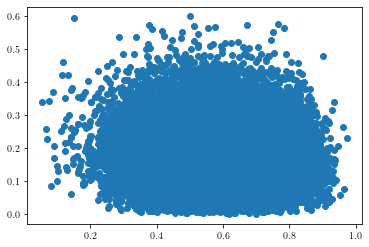

In [106]:
plt.scatter(lmod.fittedvalues, np.sqrt(abs(lmod.resid)))

In [107]:
ddf = pd.DataFrame({'x':lmod.fittedvalues, 'y':np.sqrt((abs(lmod.resid)))})
dmod = smf.ols('y~x', ddf).fit()
dmod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     33.25
Date:                Mon, 29 Aug 2022   Prob (F-statistic):           8.18e-09
Time:                        18:02:51   Log-Likelihood:                 27056.
No. Observations:               26305   AIC:                        -5.411e+04
Df Residuals:                   26303   BIC:                        -5.409e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1946      0.002     81.927      0.000       0.190       0.199
x             -0.0234      0.004     -5.767      0.000      -0.031      -0.015
==============================================================================
Omnibus:                     1193.066   Durbin-Watson:                   1.746
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1362.954
Skew:                           0.540   Prob(JB):                    1.09e-296
Kurtosis:                       3.274   Cond. No.                         10.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [108]:
# dfs for new predictions
# y_test = np.exp(df_NO2_test['NO$_2$, Stockholm Torkel Knutssonsgatan']) # y-test column back to original scale
# y_test = df_NO2_test['NO$_2$, Stockholm Torkel Knutssonsgatan'] # y-test column in original scale
# X_test = df_NO2_test[stations]

In [109]:
# log transform test data (but keep the target y in original scale)
# X_test = np.log(X_test) 
# X_test.head()
# y_test

In [110]:
# normalize X 
# X_test = scaler1.transform(X_test)
# X_test = pd.DataFrame(X_test, columns=stations)
# X_test.insert(0, 'date', index_test)
# X_test.set_index('date', inplace=True)

In [111]:
X_test.insert(0, 'intercept', 1) # insert column of ones in test data

In [112]:
# if temporal signals are to be included
X_test = X_test.merge(df_weather_test.iloc[:,s], on='date')

# if weather parameters are to be included
df_weather_test = df_weather_test.iloc[:, w]
df_weather_norm_test = (df_weather_test-df_weather_test.min())/(df_weather_test.max()-df_weather_test.min())
X_test = X_test.merge(df_weather_norm_test, on='date')

In [113]:
# check if columns in train and test matrices are same
(X_test.columns == X_train.columns).all()

True

In [114]:
# if not normalized
# y_pred_frame = np.exp(lmod.get_prediction(X_test).summary_frame()) # for confidence intervals
# y_pred = np.exp(lmod.predict(X_test))

# if normalized
y_pred = pd.DataFrame(np.exp(scaler2.inverse_transform(lmod.predict(X_test).to_frame())), columns=['NO$_2$, predictions'])
# y_pred = pd.DataFrame(scaler2.inverse_transform(lmod.predict(X_test).to_frame()), columns=['PM$_{10}$, predictions'])
y_pred.insert(0, 'date', index_test)
y_pred.set_index('date', inplace=True)

In [115]:
# metrics
print('RMSE:')
# print(np.sqrt(mean_squared_error(y_pred_frame['mean'], y_test)).round(4))
print(np.sqrt(mean_squared_error(y_pred, y_test)).round(4))

print('\nMAPE:')
# print(mean_absolute_percentage_error(y_pred_frame['mean'], y_test).round(4))
print(100*(mean_absolute_percentage_error(y_pred, y_test).round(5)))

RMSE:
3.5353

MAPE:
21.386


# Variable selection with recursive feature elimination

In [116]:
X_train_ = X_train.drop(columns='intercept', axis = 1)
X_test_ = X_test.drop(columns='intercept', axis = 1)

In [117]:
from sklearn import linear_model
from sklearn.feature_selection import RFE

reg = linear_model.LinearRegression(fit_intercept=True)
reg.fit(X_train_, y_train)

# make some predictions (check if same as lmod)
reg_pred = pd.DataFrame(np.exp(scaler2.inverse_transform(reg.predict(X_test_))), columns=['NO$_2$, predictions'])
reg_pred.insert(0, 'date', index_test)
reg_pred.set_index('date', inplace=True)
print(np.sqrt(mean_squared_error(reg_pred, y_test)).round(4))

3.5353


In [118]:
from sklearn.feature_selection import RFE
selector = RFE(reg, n_features_to_select=1)
selector = selector.fit(X_train_, y_train)
selector.ranking_

array([ 1,  2,  8,  7,  3, 11,  6, 10,  9,  5,  4])

In [119]:
X_train_.columns[np.argsort(selector.ranking_)].to_list()

['NO$_2$, Stockholm Torkel Knutssonsgatan, lag1',
 'NO$_2$, Stockholm Torkel Knutssonsgatan, lag2',
 'NO$_2$, Stockholm E4/E20 Lilla Essingen, lag1',
 'Wind speed',
 'Solar radiation',
 'Cosine day',
 'NO$_2$, Stockholm Sveavägen 59 , lag1',
 'NO$_2$, Stockholm Hornsgatan 108 , lag1',
 'Relative humidity',
 'Temperature',
 'Sine day']

In [120]:
def rmse(x,y):
    return (np.sqrt(np.mean((x-y)**2)))

In [121]:
pcols = X_train_.shape[1]
prefs = np.argsort(selector.ranking_)
valpred = np.empty(pcols + 1)
valpred[0] = rmse(y_val, np.mean(y_train.values))
trainpred = np.empty(pcols + 1)
trainpred[0] = rmse(y_train, np.mean(y_train))

/Users/simoncarlen/opt/miniconda3/envs/DL/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


(0.0, 21.0)

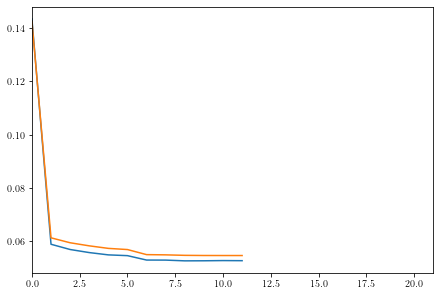

In [122]:
for k in range(1, pcols+1):
    reg = linear_model.LinearRegression(fit_intercept=True)
    reg.fit(X_train_.iloc[:, prefs[0:k]], y_train)
    y_pred = reg.predict(X_val.iloc[:, prefs[0:k]])
    valpred[k] = np.sqrt(mean_squared_error(y_pred, y_val))
    y_pred_ = reg.predict(X_train_.iloc[:, prefs[0:k]])
    trainpred[k] = np.sqrt(mean_squared_error(y_pred_, y_train))
# valpred.round(6)
# trainpred.round(6)

fig, ax = plt.subplots(constrained_layout=True)
ax.plot(valpred)
ax.plot(trainpred)
ax.set_xlim(0,21)

In [123]:
min(valpred).round(3)

0.053

# Robust regression

In [124]:
rlmod = sm.RLM(y_train, X_train).fit()
print(rlmod.summary().as_latex())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}                                   & NO\$\_2\$, Torkel Knutssonsgatan & \textbf{  No. Observations:  } &    26305    \\
\textbf{Model:}                                           &               RLM                & \textbf{  Df Residuals:      } &    26293    \\
\textbf{Method:}                                          &               IRLS               & \textbf{  Df Model:          } &       11    \\
\textbf{Norm:}                                            &              HuberT              & \textbf{                     } &             \\
\textbf{Scale Est.:}                                      &               mad                & \textbf{                     } &             \\
\textbf{Cov Type:}                                        &                H1                & \textbf{                     } &             \\
\textbf{Date:}                                            &         Mon, 29 Aug 2022         & \

In [125]:
# print(np.sqrt(mean_squared_error(np.exp(scaler2.inverse_transform(rlmod.predict(X_test))), y_test)).round(5))
y_pred_robust = pd.DataFrame(np.exp(scaler2.inverse_transform(rlmod.predict(X_test).to_frame())), columns = ['NO$_2$, predictions'])
# y_pred_robust = pd.DataFrame(scaler2.inverse_transform(rlmod.predict(X_test).to_frame()), columns = ['PM$_{10}$, predictions'])
y_pred_robust.insert(0, 'date', index_test)
y_pred_robust.set_index('date', inplace=True)

In [126]:
# metrics
print('RMSE:')
# print(np.sqrt(mean_squared_error(y_pred_frame['mean'], y_test)).round(4))
print(np.sqrt(mean_squared_error(y_pred_robust, y_test)).round(3))

print('\nMAPE:')
# print(mean_absolute_percentage_error(y_pred_frame['mean'], y_test).round(4))
print(100*(mean_absolute_percentage_error(y_pred_robust, y_test).round(5)))

RMSE:
3.513

MAPE:
21.295


In [127]:
y_pred_robust['NO$_2$'] = y_test


In [128]:
y_pred_robust.to_csv('../prediction_results/robust_regression.csv')

# Scikit learns huber regression

In [130]:
from sklearn.linear_model import HuberRegressor
huber = HuberRegressor(max_iter=10000).fit(X_train_, y_train.values.ravel())
y_predHuber = huber.predict(X_test.drop(columns='intercept', axis=1))
x = pd.DataFrame({'pred':y_predHuber})

print(np.sqrt(mean_squared_error(np.exp(scaler2.inverse_transform(x)), y_test.values)).round(3))
print(100*(mean_absolute_percentage_error(np.exp(scaler2.inverse_transform(x)), y_test.values)).round(5))

3.508
21.247


In [131]:
# huber.coef_;
selector_ = RFE(huber, n_features_to_select=1)
selector_ = selector.fit(X_train_, y_train.values.ravel())
selector_.ranking_
X_train_.columns[np.argsort(selector_.ranking_)].to_list()

['NO$_2$, Stockholm Torkel Knutssonsgatan, lag1',
 'NO$_2$, Stockholm Torkel Knutssonsgatan, lag2',
 'NO$_2$, Stockholm E4/E20 Lilla Essingen, lag1',
 'Wind speed',
 'Solar radiation',
 'Cosine day',
 'NO$_2$, Stockholm Sveavägen 59 , lag1',
 'NO$_2$, Stockholm Hornsgatan 108 , lag1',
 'Relative humidity',
 'Temperature',
 'Sine day']

In [132]:
pcols = X_train_.shape[1]
prefs = np.argsort(selector.ranking_)
valpred = np.empty(pcols+1)
valpred[0] = rmse(y_val, np.mean(y_train.values))
trainpred = np.empty(pcols+1)
trainpred[0] = rmse(y_train, np.mean(y_train))

/Users/simoncarlen/opt/miniconda3/envs/DL/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [133]:
valpred[0] = np.NaN
trainpred[0] = np.NaN

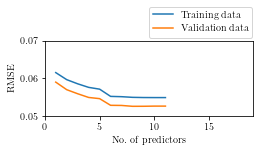

In [134]:

for k in range(1,pcols+1):
    huber = HuberRegressor(max_iter=10000)
    huber.fit(X_train_.iloc[:, prefs[0:k]], y_train.values.ravel())
    y_pred = huber.predict(X_val.iloc[:, prefs[0:k]])
    valpred[k] = np.sqrt(mean_squared_error(y_pred, y_val))
    # valpred.append(np.sqrt(mean_squared_error(y_pred, y_val)))
    y_pred_ = huber.predict(X_train_.iloc[:, prefs[0:k]])
    trainpred[k] = np.sqrt(mean_squared_error(y_pred_, y_train))
    # trainpred.append(np.sqrt(mean_squared_error(y_pred_, y_train)))

fig, ax = plt.subplots(constrained_layout = True, figsize = (3.5, 2))# ax1.plot(testpred, label='Testdata')
ax.plot(trainpred, label='Training data')
ax.plot(valpred, label='Validation data')
ax.set_xlim(0,19)
ax.set_ylim(0.05, 0.07)
ax.set_xlabel('No.\ of predictors')
ax.set_ylabel('RMSE')
ax.legend(loc='lower right', bbox_to_anchor= (1.0, 1.025), ncol=1, borderaxespad=0.1)
# plt.savefig('../plots/RMSE_predictors.pdf')

In [46]:
# X_train_val = pd.concat([X_train_, X_val])
# y_train_val = pd.concat([y_train, y_val])

In [47]:
# from sklearn.feature_selection import RFECV
# selector = RFECV(huber, step=1, cv=10, scoring='neg_mean_squared_error')
# selector = selector.fit(X_train_val, y_train_val.values.ravel())

# plt.plot(np.arange(1, 21), -selector.grid_scores_)
# plt.xlabel('No.\ of predictors')
# plt.ylabel('MSE')
# plt.savefig('../plots/RMSE_predictors_cross_val.pdf')